In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The BrainLat dataset contains neuroimaging and cognitive data from 780 subjects, including patients with AD (N =278), bvFTD (N =163), PD (N =57) and MS (N =32), and HCs (N =250).

Alzheimer's disease (AD), behavioral variant frontotemporal dementia (bvFTD), multiple sclerosis (MS), Parkinson's disease (PD), and healthy controls (HCs).

Using the MNE library to visualize and process .set data [MNE](https://mne.tools/stable/index.html)

In [ ]:
!pip install mne
import mne
import numpy as np
from scipy.signal import stft
import os
import cv2

<ipython-input-5-73a98f9576a9>:4: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab("/content/drive/MyDrive/BrainLat/EEG data/1_AD/AR/sub-30015/eeg/s6_sub-30015_rs-HEP_eeg.set")


Using matplotlib as 2D backend.


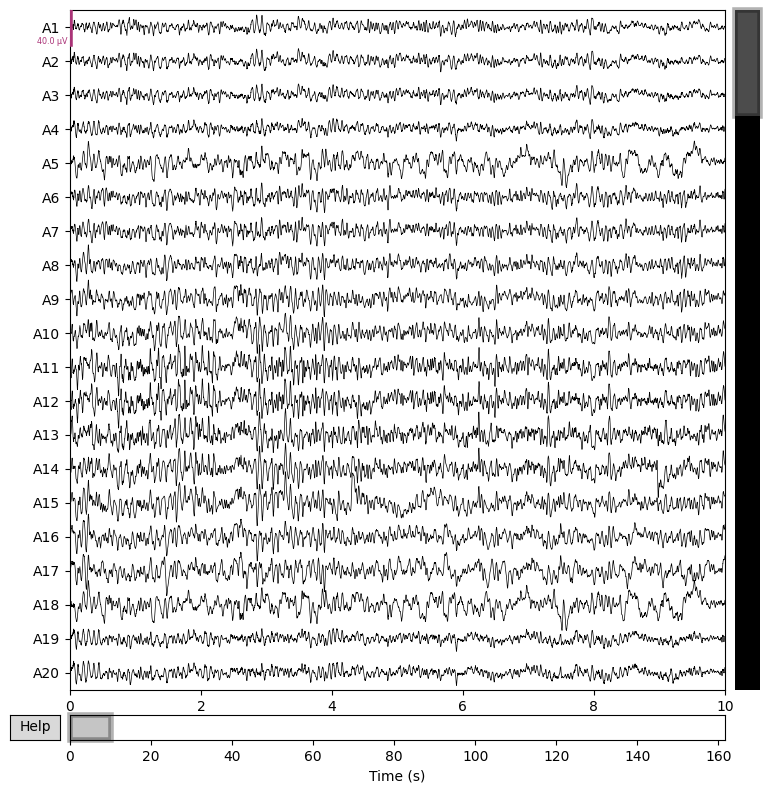

In [ ]:
# Load the .set file
raw = mne.io.read_raw_eeglab("/content/drive/MyDrive/BrainLat/EEG data/1_AD/AR/sub-30015/eeg/s6_sub-30015_rs-HEP_eeg.set")
# Visualize the data
raw.plot()
# Extract data
# Get data from all channels
data = raw.get_data(picks=raw.ch_names)
# Get data from raw object
data = raw.get_data()
# Get time points
times = raw.times
# Get sampling frequency
fs = raw.info['sfreq']

## STFT Y FFT EEG

In [ ]:
# Base directories for data and saving
base_data_path = '/content/drive/MyDrive/BrainLat/EEG data original'
base_save_path = '/content/drive/MyDrive/BrainLat/EEGIMG2'

# Folders of interest containing different classes of data
folders_of_interest = ['5_HC']  # You can add more folders: '1_AD', '2_bvFTD', '5_HC'

# Function to resize the STFT image using OpenCV
def resize_stft_with_opencv(stft_result, target_shape=(224, 224)):
    resized_stft = cv2.resize(stft_result, target_shape, interpolation=cv2.INTER_CUBIC)
    return resized_stft

# Dictionary to accumulate data by class
stft_per_class = {cls: [] for cls in folders_of_interest}

# Loop through each folder of interest
for folder in folders_of_interest:
    # Loop through each condition (AR and CL)
    for condition in ['AR', 'CL']:
        current_folder_path = os.path.join(base_data_path, folder, condition)

        # Skip if the current folder path does not exist
        if not os.path.exists(current_folder_path):
            continue

        # Get the list of sub-folders
        sub_folders = next(os.walk(current_folder_path))[1]

        # Loop through each sub-folder
        for sub_folder in sub_folders:
            eeg_folder_path = os.path.join(current_folder_path, sub_folder, 'eeg')

            # Skip if the eeg folder path does not exist
            if not os.path.exists(eeg_folder_path):
                continue

            # Loop through each file in the eeg folder
            for file in os.listdir(eeg_folder_path):
                # Process only .set files
                if file.endswith('.set'):
                    set_file_path = os.path.join(eeg_folder_path, file)

                    try:
                        # Read the raw EEG data using MNE
                        raw = mne.io.read_raw_eeglab(set_file_path, preload=True)
                        data = raw.get_data()
                        fs = raw.info['sfreq']

                        # Process STFT and FFT
                        stft_resized_list = []
                        for i in range(data.shape[0]):  # Iterate over channels
                            # Compute the STFT
                            f, _, Zxx = stft(data[i], fs, nperseg=4*fs, noverlap=3*fs, nfft=5.6*fs)  # Frequency, time, and FFT resolution
                            freq_index = np.where(f <= 40)[0][-1]  # Find the index where frequency is approximately 40Hz
                            s = np.abs(Zxx)[:freq_index+1, :]
                            s = resize_stft_with_opencv(np.flipud(s))  # Resize and flip the STFT result
                            stft_resized_list.append(s)

                        # Transpose and store the STFT result
                        stft_per_class[folder].append(np.transpose(np.array(stft_resized_list), (1, 2, 0)))
                    except FileNotFoundError as e:
                        print(f"Could not load file: {set_file_path}")
                        print(e)

# Save the accumulated data by class
for cls in folders_of_interest:
    class_save_path = os.path.join(base_save_path, cls)
    os.makedirs(class_save_path, exist_ok=True)
    np.save(os.path.join(class_save_path, "stft.npy"), np.array(stft_per_class[cls]))